In [1]:
import copy
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle
from mxlpy import Model, Simulator, scan
from mxlpy.parallel import parallelise

sys.path.append(os.path.abspath('..'))

from model import Fuente2024

here = Path().absolute()

def save_fig(fig_num: str) -> Path:
    here = Path().absolute()
    name = "Fuente2024"
    plt.savefig(here / f"{name.lower()}_fig{fig_num}.svg", format="svg", bbox_inches="tight")

## Str Dictionary

In [2]:
pfd_str = "PPFD"
pfd_add_str = "PPFD_add"
f_str = "f"
light_str = "osc_light"
pqox_str = "PQ"
hlumen_str = "H_lumen"
qactive_str = "Q_active"
atp_stroma_str = "ATP_st"
atot_str = "AP_tot"
ps1ox_str = "PSI_ox"
ps1total_str = "PSI_total"
o2_str = "O2"
npq_str = "NPQ"
flou_str = "Fluo"
pqtotal_str = "PQ_tot"

# Figure 2

In [3]:
def fig2_sim(
    m: Model,
    pfd_str: str,
    pfd_add_str: str,
    f_str: str
):
    pfd = np.mean([50, 950])
    
    m.update_parameters({
        f_str: 1 / 10000,
        pfd_str: pfd,
        pfd_add_str: 950 - pfd
    })

    s = Simulator(m)

    s.simulate(40000)

    res = s.get_result().unwrap_or_err().get_combined()

    return res, m

def fig2_plot(
    res: pd.DataFrame,
    m: Model,
    light_str: str,
    pqox_str: str,
    hlumen_str: str,
    qactive_str: str,
    atp_stroma_str: str,
    atot_str: str,
    ps1ox_str: str
):
    
    fig, axs = plt.subplots(3, 2, figsize=(10, 8))

    light_diff = res[light_str].diff()
    light_color = "#fdb338ff"
    dark_color = "#025196ff"

    new_res = pd.DataFrame()
    new_res["light"] = res[light_str]
    new_res["pq_ox"] = res[pqox_str]
    new_res["-log_Hlumen"] = -np.log10(res[hlumen_str] * 10**(-6))
    new_res["quencher_active"] = res[qactive_str]
    new_res["atp_stroma_ratio"] = res[atp_stroma_str] / m.get_parameter_values()[atot_str]
    new_res["ps1_ox"] = res[ps1ox_str]


    for ax, res_str in zip(axs.flatten(), new_res.columns, strict=False):
        points = np.array([new_res.index, new_res[res_str].values]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        colors = np.where(light_diff >= 0, light_color, dark_color)
        lc = LineCollection(segments, colors=colors, linewidths=2)

        ax.add_collection(lc)
        
        ax.set_xlim(new_res.index.min(), new_res.index.max())
        ax.set_ylim(new_res[res_str].min(), new_res[res_str].max())

    for ax in axs.flatten():
        ax.set_xlim(2e4, 4e4)
        ax.set_xticks(np.linspace(2e4, 4e4, 5))
        ax.set_xlabel("Time (s)")
        
    axs[0,0].set_ylabel("Light Intensity (µmol photons m$^{-2}$ s$^{-1}$)")
    axs[0,0].set_ylim(0, 1100)
    axs[0,0].set_yticks(np.linspace(0, 1000, 6))

    axs[0,1].set_ylabel(r"Oxidized PQ (PQ $\cdot$ PSII$^{-1}$)")
    axs[0,1].set_ylim(1, 5)
    axs[0,1].set_yticks(np.linspace(1, 5, 5))

    axs[1,0].set_ylabel(r"Lumen pH")
    axs[1,0].set_ylim(5.6, 6.6)
    axs[1,0].set_yticks(np.linspace(5.6, 6.6, 6))

    axs[1,1].set_ylabel(r"Active quencher (rel. units)")
    axs[1,1].set_ylim(0, 1)
    axs[1,1].set_yticks(np.linspace(0, 1, 6))

    axs[2,0].set_ylabel(r"ATP/Stroma Ratio")
    axs[2,0].set_ylim(0, 1)
    axs[2,0].set_yticks(np.linspace(0, 1, 6))

    axs[2,1].set_ylabel(r"PI$_{ox}$ (rel. units)")
    axs[2,1].set_ylim(0, 0.8)
    axs[2,1].set_yticks(np.linspace(0, 0.8, 5))

    return fig, axs

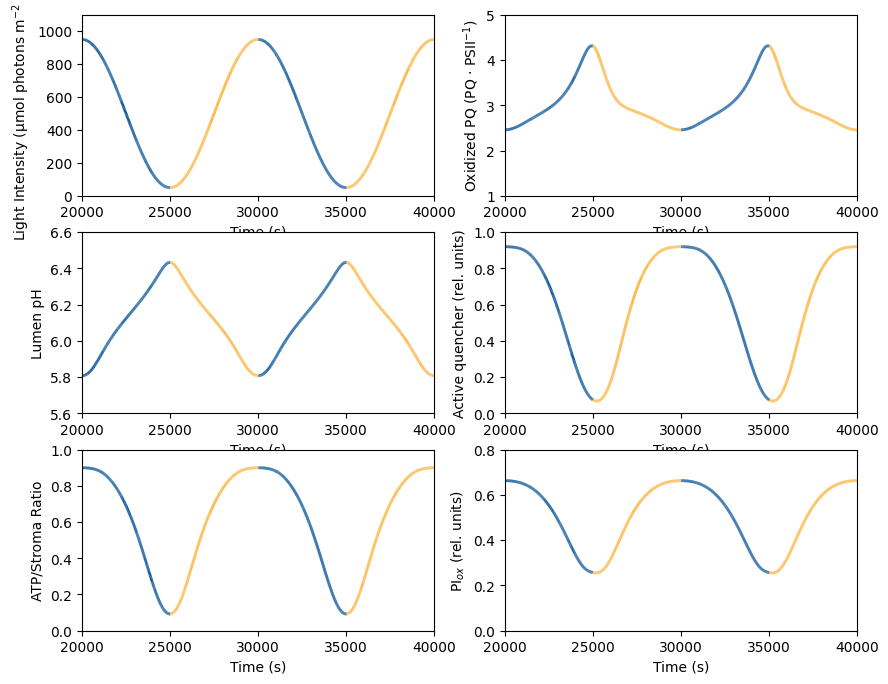

In [4]:
fig2_res, fig2_m = fig2_sim(
    m=Fuente2024(),
    pfd_str=pfd_str,
    pfd_add_str=pfd_add_str,
    f_str=f_str
)

fig2, axs2 = fig2_plot(
    res=fig2_res,
    m=fig2_m,
    light_str=light_str,
    pqox_str=pqox_str,
    hlumen_str=hlumen_str,
    qactive_str=qactive_str,
    atp_stroma_str=atp_stroma_str,
    atot_str=atot_str,
    ps1ox_str=ps1ox_str
)

save_fig("2")

# Figure 3

In [5]:
def fig3_sim(
    m: Model,
    pfd_str: str,
    pfd_add_str: str
):
    m.update_parameters({
        pfd_add_str: 0
    })
    
    res = scan.steady_state(
        model=m,
        to_scan=pd.DataFrame({
            pfd_str: np.linspace(10, 1000, 100)
        })
    )
    
    return res.combined, m

def fig3_plot(
    m: Model,
    res: pd.DataFrame,
    atp_stroma_str: str,
    atot_str: str,
    qactive_str: str,
    hlumen_str: str,
    ps1ox_str: str,
    ps1total_str: str,
    pqox_str: str,
    pqtotal_str: str,
    o2_str: str,
    npq_str: str,
    flou_str: str
):
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
    
    new_res = pd.DataFrame()
    new_res["atp_stroma"] = res[atp_stroma_str] / m.get_parameter_values()[atot_str]
    new_res["active_quencher"] = res[qactive_str]
    new_res["lumen_pH"] = -np.log10(res[hlumen_str] * 10**(-6))
    new_res["ps1_ox"] = res[ps1ox_str] / m.get_parameter_values()[ps1total_str]
    new_res["pq_ox"] = res[pqox_str] / m.get_parameter_values()[pqtotal_str]
    new_res["o2"] = res[o2_str]
    new_res["npq"] = res[npq_str]
    new_res["flou"] = res[flou_str]
    
    
    style_dict = {
        "atp_stroma": {
            "color": "#8eb133",
            "label": "ATP"
        },
        "active_quencher": {
            "color": "#e19d20",
            "label": "Active Quencher"
        },
        "lumen_pH": {
            "color": "#000000",
            "label": "Lumen pH"
        },
        "ps1_ox": {
            "color": "#f16431",
            "label": "PI$_{ox}$"
        },
        "pq_ox": {
            "color": "#5f7fb6",
            "label": "Oxidized PQ"
        },
        "o2": {
            "color": "#000000",
            "label": "O$_2$ evolution"
        },
        "npq": {
            "color": "#e29c23",
            "label": "NPQ"
        },
        "flou": {
            "color": "#5b82b5",
            "label": "ChlF"
        }
    }
    
    ax_lumen = axs[0].twinx()
    ax_o2 = axs[1].twinx()
    
    for col_str in new_res.columns:
        if col_str == "lumen_pH":
            ax = ax_lumen
        elif col_str == "o2":
            ax = ax_o2
        elif col_str in ["npq", "flou"]:
            ax = axs[1]
        else:
            ax = axs[0]
        ax.plot(
            new_res.index,
            new_res[col_str],
            color=style_dict[col_str]["color"],
            linewidth=2
        )
        
    for ax in axs:
        ax.set_xlabel(r"Light Intensity (µmol photons $\cdot$ m$^{-2}$ $\cdot$ s$^{-1}$)")
        ax.set_xlim(-10, 1010)
        ax.set_xticks(np.linspace(0, 1000, 6))
        
        ax.add_patch(
            Rectangle(
                (0, ax.get_ylim()[0]),
                50,
                ax.get_ylim()[1] - ax.get_ylim()[0],
                color="black",
                alpha=0.1,
                zorder=-1
            )
        )
        
    axs[0].set_ylabel("Concentrations Ratios")
    axs[0].set_ylim(0, 0.9)
    axs[0].set_yticks(np.linspace(0.2, 0.8, 4))
    ax_lumen.set_ylabel("Lumen pH")
    ax_lumen.set_ylim(5.0, 6.8)
    ax_lumen.set_yticks(np.linspace(5.4, 6.6, 4))
    
    axs[1].set_ylabel("NPQ \n ChlF (rel. units)")
    axs[1].set_ylim(0, 1.25)
    axs[1].set_yticks(np.linspace(00, 1.2, 7))
    ax_o2.set_ylabel(r"O$_2$ rate \n (mol O$_2$ $\cdot$ mol PSIIRC$^{-1}$ $\cdot$ s$^{-1}$)")
    ax_o2.set_ylim(0, 121)
    ax_o2.set_yticks(np.linspace(0, 120, 7))
    
    
    return fig, axs

100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


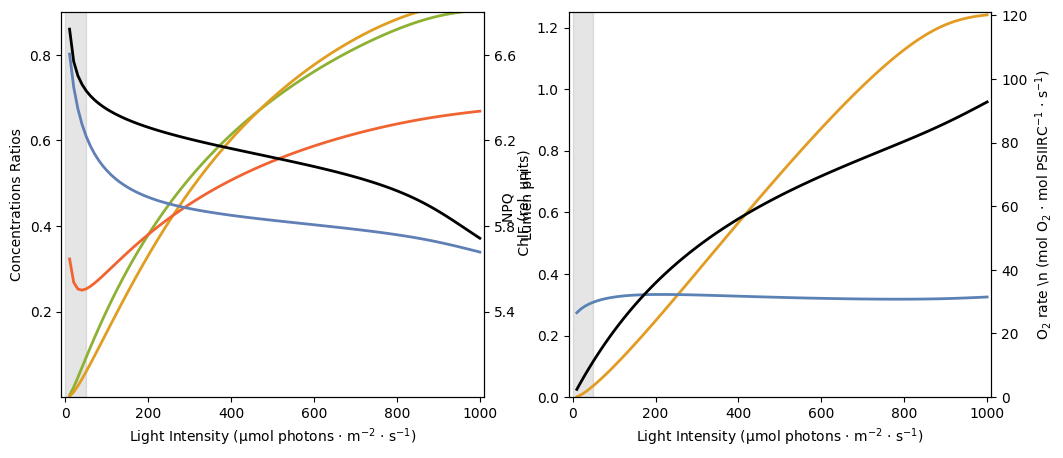

In [6]:
fig3_res, fig3_m = fig3_sim(
    m=Fuente2024(),
    pfd_str=pfd_str,
    pfd_add_str=pfd_add_str
)

fig3, axs3 = fig3_plot(
    m=fig3_m,
    res=fig3_res,
    atp_stroma_str=atp_stroma_str,
    atot_str=atot_str,
    qactive_str=qactive_str,
    hlumen_str=hlumen_str,
    ps1ox_str=ps1ox_str,
    ps1total_str=ps1total_str,
    pqox_str=pqox_str,
    pqtotal_str=pqtotal_str,
    o2_str=o2_str,
    npq_str=npq_str,
    flou_str=flou_str
)

save_fig("3")

# Figure 4

In [7]:
def fig4_parralel_func(dic):
    s = Simulator(dic["model"])
    
    s.update_parameter(dic["f_str"], dic["f_val"])
    
    s.simulate(dic["sim_end"])
    
    return s.get_result().unwrap_or_err().get_combined()

def fig4_sim(
    m: Model,
    pfd_str: str,
    pfd_add_str: str,
    f_str: str
):
    
    full_res = None
    pfds = [(50, 950), (50, 150)]
    Ts = [10000, 1000, 100, 1, 0.1, 0.001]
    sim_ends = [50000, 5000, 500, 5, 0.5, 0.005]
    
    for pfd_vals in pfds:
        model_copy = copy.deepcopy(m)
        model_copy.update_parameters({
            pfd_str: np.mean(pfd_vals),
            pfd_add_str: pfd_vals[1] - np.mean(pfd_vals)
        })

        res = parallelise(
            fn=fig4_parralel_func,
            inputs=[(T, {"model": model_copy, "f_val": 1/T, "sim_end": s, "f_str": f_str}) for i, (T, s) in enumerate(zip(Ts, sim_ends))],
        )
        
        res = pd.concat([i[1] for i in res], keys=[i[0] for i in res], names=["T", "time"])
        
        if full_res is None:
            full_res = pd.concat([res], keys=[f"{pfd_vals}"], names=["pfds"])
        else:
            full_res = pd.concat([full_res, pd.concat([res], keys=[f"{pfd_vals}"], names=["pfds"])])
        
    return full_res, model_copy

def fig4_plot(
    res: pd.DataFrame,
    m: Model,
    pqox_str: str,
    hlumen_str: str,
    qactive_str: str,
    atp_stroma_str: str,
    atot_str: str,
    ps1ox_str: str,
    light_str: str,
):
    
    fig, axs = plt.subplots(ncols=5, nrows=6, figsize=(20, 20))
    
    
    light_color = "#fdb338ff"
    dark_color = "#025196ff"
    
    dash_pattern = (0, (1, 2))
    
    xlims = [(2e4, 4e4), (2e3, 4e3), (2e2, 4e2), (2e0, 4e0), (2e-1, 4e-1), (2e-3, 4e-3)]
    ylims = [(1, 6), (5.5, 7.0), (0, 1), (0, 1.0), (0, 1)]
    titles = [
        r"Oxidized PQ (PQ $\cdot$ PSII$^{-1}$)",
        r"Lumen pH",
        r"Active quencher (rel. units)",
        r"ATP / Total Adenosines",
        r"PI$_{ox}$ (rel. units)"
    ]
    
    for pfds in res.index.get_level_values("pfds").unique():
        new_res_pfds = res.loc[pfds]
        
        current_ls = "solid" if pfds == "(50, 950)" else dash_pattern
        
        for row, T in enumerate(res.index.get_level_values('T').unique()):
            new_res = new_res_pfds.loc[T]
            true_res = pd.DataFrame()
            true_res["pq_ox"] = new_res[pqox_str]
            true_res["-log_Hlumen"] = -np.log10(new_res[hlumen_str] * 10**(-6))
            true_res["quencher_active"] = new_res[qactive_str]
            true_res["atp_stroma_ratio"] = new_res[atp_stroma_str] / m.get_parameter_values()[atot_str]
            true_res["ps1_ox"] = new_res[ps1ox_str]
            
            light_diff = new_res[light_str].diff().fillna(0)
            for col, res_str in enumerate(true_res.columns):
            
                points = np.array([true_res.index, true_res[res_str].values]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                colors = np.where(light_diff >= 0, light_color, dark_color)
                lc = LineCollection(
                    segments, 
                    colors=colors, 
                    linewidths=2, 
                    linestyles=current_ls,
                    capstyle="butt",
                    zorder=1
                )

                axs[row,col].add_collection(lc)
                if current_ls != "solid":
                    axs[row,col].plot(true_res[res_str], color="white", lw=2.5, zorder=2, ls=dash_pattern)
                
                axs[row,col].set_ylim(ylims[col])
                
                if row == 0:
                        axs[0,col].set_title(titles[col])
                if row == len(res.index.get_level_values('T').unique()) - 1:
                    axs[row,col].set_xlabel("Time (s)")

            for ax in axs[row, :]:
                ax.set_xlim(xlims[row])
                ax.set_xticks(np.linspace(xlims[row][0], xlims[row][1], 5))
                
            axs[row,0].set_ylabel(f"T = {T} s")
                
    
    return fig, axs

100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


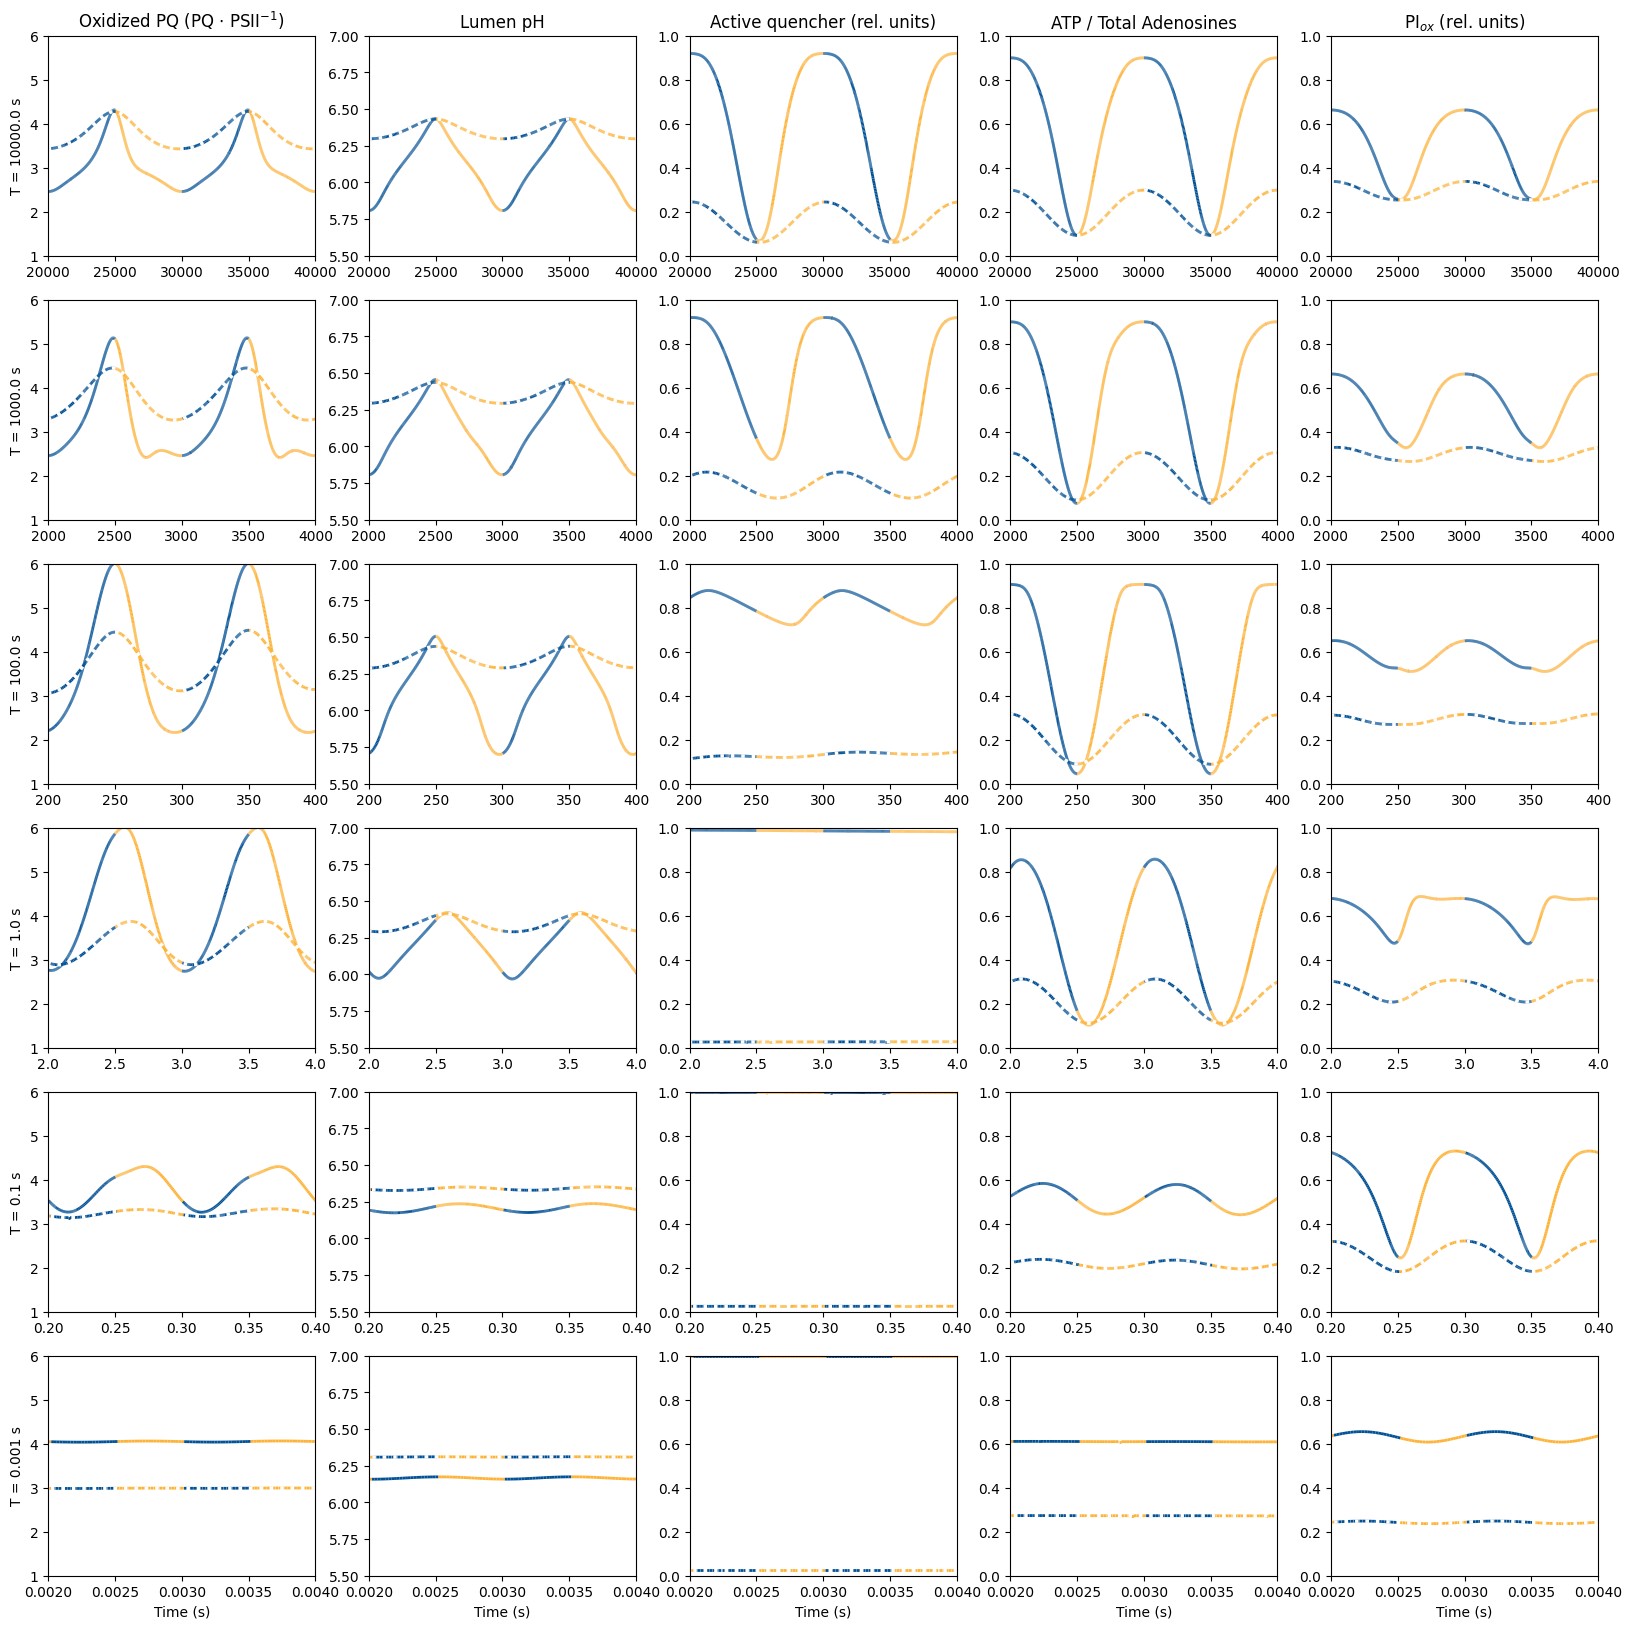

In [8]:
fig4_res, fig4_model = fig4_sim(
    m=Fuente2024(),
    pfd_str=pfd_str,
    pfd_add_str=pfd_add_str,
    f_str=f_str
)

fig4_plot(
    res=fig4_res,
    m=fig4_model,
    pqox_str=pqox_str,
    hlumen_str=hlumen_str,
    qactive_str=qactive_str,
    atp_stroma_str=atp_stroma_str,
    atot_str=atot_str,
    ps1ox_str=ps1ox_str,
    light_str=light_str
)

save_fig("4")

# Figure 5

In [9]:
def fig5_plot(
    res: pd.DataFrame,
    m: Model,
    light_str: str,
    o2_str: str,
    npq_str: str,
    flou_str: str
):
    
    fig, axs = plt.subplots(ncols=3, nrows=6, figsize=(20, 20))
    
    
    light_color = "#fdb338ff"
    dark_color = "#025196ff"
    
    dash_pattern = (0, (1, 2))
    
    xlims = [(2e4, 4e4), (2e3, 4e3), (2e2, 4e2), (2e0, 4e0), (2e-1, 4e-1), (2e-3, 4e-3)]
    ylims = [(0, 0.5), (0, 1.5), (0, 120)]
    titles = [
        r"ChlF (rel. units)",
        r"NPQ",
        r"O$_2$ rate \n (mol O$_2$ $\cdot$ mol PSIIRC$^{-1}$ $\cdot$ s$^{-1}$)"
    ]
    
    for pfds in res.index.get_level_values("pfds").unique():
        new_res_pfds = res.loc[pfds]
        
        current_ls = "solid" if pfds == "(50, 950)" else dash_pattern
        
        for row, T in enumerate(res.index.get_level_values('T').unique()):
            new_res = new_res_pfds.loc[T]
            true_res = pd.DataFrame()
            true_res["flou"] = new_res[flou_str]
            true_res["npq"] = new_res[npq_str]
            true_res["o2"] = new_res[o2_str]
            
            light_diff = new_res[light_str].diff().fillna(0)
            for col, res_str in enumerate(true_res.columns):
            
                points = np.array([true_res.index, true_res[res_str].values]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                colors = np.where(light_diff >= 0, light_color, dark_color)
                lc = LineCollection(
                    segments, 
                    colors=colors, 
                    linewidths=2, 
                    linestyles=current_ls,
                    capstyle="butt",
                    zorder=1
                )

                axs[row,col].add_collection(lc)
                if current_ls != "solid":
                    axs[row,col].plot(true_res[res_str], color="white", lw=2.5, zorder=2, ls=dash_pattern)
                
                axs[row,col].set_ylim(ylims[col])
                
                if row == 0:
                        axs[0,col].set_title(titles[col])
                if row == len(res.index.get_level_values('T').unique()) - 1:
                    axs[row,col].set_xlabel("Time (s)")

            for ax in axs[row, :]:
                ax.set_xlim(xlims[row])
                ax.set_xticks(np.linspace(xlims[row][0], xlims[row][1], 5))
                
            axs[row,0].set_ylabel(f"T = {T} s")
                
    
    return fig, axs

100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


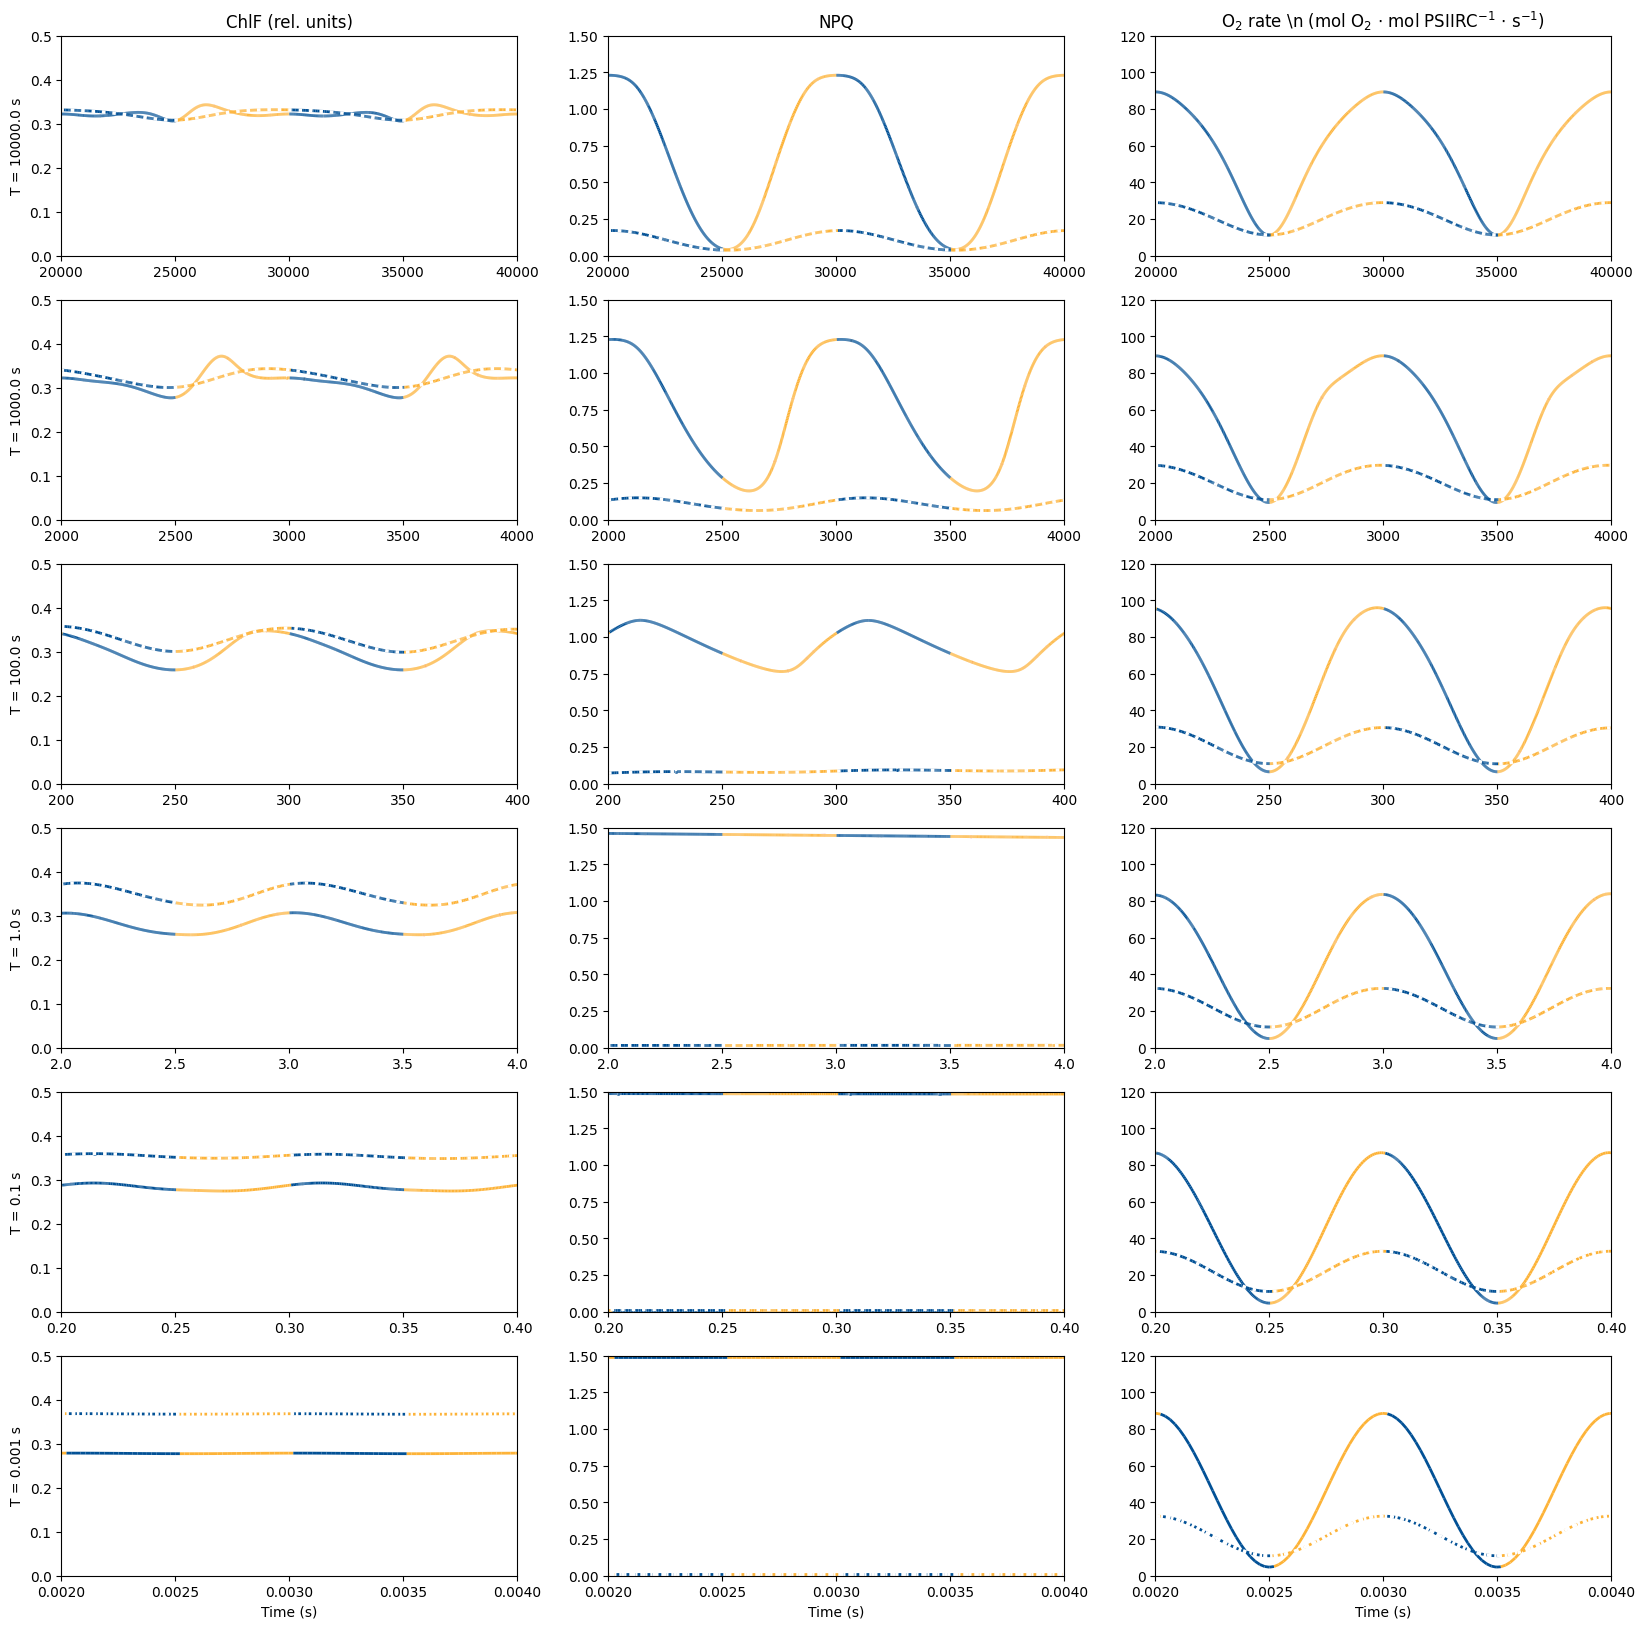

In [ ]:
fig5_res, fig5_model = fig4_sim(
    m=Fuente2024(),
    pfd_str=pfd_str,
    pfd_add_str=pfd_add_str,
    f_str=f_str
)

fig5_plot(
    res=fig5_res,
    m=fig5_model,
    light_str=light_str,
    o2_str=o2_str,
    npq_str=npq_str,
    flou_str=flou_str
)

save_fig("5")